In [106]:
import pandas as pd
import os 
import re
import matplotlib.pyplot as plt
import numpy as np

In [51]:
dat = pd.read_csv('../logs/stat_ext.txt',sep='\t',header=None,names=['app_id','filename','cnt','f','m','f18','f25','f35',
             'f45','f55','f65','m18','m25','m35','m45','m55','m65'])
dat = dat.sort_values('cnt',ascending=False).drop_duplicates(subset='filename').sort_values('filename').drop('app_id',axis=1)


In [150]:
def agg_gender(df, with_cnt=False):
    brackets=['18','25','35','45','55','65']
    dat = pd.DataFrame()
    dat['filename']=df['filename']
    if with_cnt:
        dat['cnt']=df['cnt']
    for brac in brackets:
        mbrac, fbrac='m'+brac, 'f'+brac
        dat[brac] = df['m']*df[mbrac]+df['f']*df[fbrac]
    return dat

def double_axis(f_cnt,f_acc,main,y1,y2):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('threshold')
    ax1.set_ylabel(y1, color=color)
    ax1.plot([0.65,0.7,0.75,0.8,0.85,0.9], f_cnt, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel(y2, color=color)  # we already handled the x-label with ax1
    ax2.plot([0.65,0.7,0.75,0.8,0.85,0.9], f_acc, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(main)
    plt.show()
    
def recall_ext(row,clss):
    dist = agg_gender(dat.loc[dat.filename=='age_demo_171231_us'])
    clsses = ['18','25','35','45','55','65']
    rec = float(row[clss])*float(dist[clss])/sum(float(row[i])*float(dist[i]) for i in clsses)
    return rec

# Age Bracket Demography for Training Labels

In [79]:
dat_age_demo = dat.loc[dat.filename.str.contains('^age_\d\d_samp')]
age_demo = agg_gender(dat_age_demo,with_cnt=True)
age_demo.index=range(age_demo.shape[0])
age_demo = age_demo.drop(0)
two_dig = re.compile(r'_\d\d_')
acc = []
for i in range(1,7):
    acc.append(age_demo[two_dig.search(age_demo.filename[i]).group()[1:3]][i])
age_demo

,filename,cnt,18,25,35,45,55,65
1,age_18_samp,4546800,0.532585,0.226095,0.104300,0.064300,0.038845,0.033845
2,age_25_samp,6643500,0.164797,0.460567,0.153357,0.106538,0.070005,0.044736
3,age_35_samp,910600,0.046451,0.093647,0.685842,0.089627,0.039785,0.044648
4,age_45_samp,506200,0.055210,0.091304,0.147398,0.619718,0.061486,0.023884
5,age_55_samp,238100,0.048952,0.085508,0.186808,0.132064,0.471888,0.074288
6,age_65_samp,155200,0.054695,0.102688,0.371177,0.185085,0.072915,0.213362


## Precision for Each Bracket

In [78]:
brackets=['18','25','35','45','55','65']
[[brackets[i],acc[i]] for i in range(6)]

[['18', 0.53258499999999998],
 ['25', 0.460567],
 ['35', 0.68584200000000006],
 ['45', 0.61971799999999999],
 ['55', 0.47188800000000003],
 ['65', 0.213362]]

## Recall for Each Bracket

In [84]:
rec = []
for i in range(1,7):
    cname = two_dig.search(age_demo.filename[i]).group()[1:3]
    rec.append((age_demo['cnt']*age_demo[cname])[i]/(age_demo['cnt']*age_demo[cname]).sum())
[[brackets[i],rec[i]] for i in range(6)]

[['18', 0.67139113550665708],
 ['25', 0.71900428471749989],
 ['35', 0.27221021019593655],
 ['45', 0.21550897031481173],
 ['55', 0.13492649137689083],
 ['65', 0.059703374995586402]]

Above is the precision and recall for our training labels. The precision is ok for bracket '35' and '45' and recall is ok for '18' and '25'. However, all the other statstitcs are very poor. As we discussed yesterday, I think the first priority is still to improve the label accuracy.

# Predicted Gender

In [127]:
gender_dat = dat.loc[dat.filename.str.contains('gender_\d\d\d\d\d\d_[fm]_us_\d\d')]
gender_demo = gender_dat[['filename','f','m']]
with open('../../age_gender/python/logs/thres_cnt_f.txt') as fc:
    f_cnt = fc.read()
with open('../../age_gender/python/logs/thres_cnt_m.txt') as mc:
    m_cnt = mc.read()
f_cnt = pd.Series(f_cnt.split('\n')[:-1]).astype('float')
m_cnt = pd.Series(m_cnt.split('\n')[:-1]).astype('float')
f_acc = gender_demo.iloc[:5,1]
m_acc = gender_demo.iloc[5:,2]
f_acc = f_acc.append(pd.Series([0.79]))
m_acc = m_acc.append(pd.Series([0.83]))
print('Thresholds: ',[0.65,0.7,0.75,0.8,0.85,0.9])
print('# of record for male: ',m_cnt.values.tolist())
print('# of record for female: ',f_cnt.values.tolist())
print('Accuracy for male: ',m_acc.values.tolist())
print('Accuracy for female: ',f_acc.values.tolist())

Thresholds:  [0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
# of record for male:  [119659779.0, 97876548.0, 78071943.0, 60921322.0, 45829300.0, 31851948.0]
# of record for female:  [180272436.0, 148343543.0, 116345888.0, 86564131.0, 60894140.0, 39208514.0]
Accuracy for male:  [0.7090000000000001, 0.728, 0.748, 0.7709999999999999, 0.7979999999999999, 0.83]
Accuracy for female:  [0.677, 0.696, 0.716, 0.7390000000000001, 0.764, 0.79]


## Plot for Number of Estimations vs Threshold and Accuracy vs Threshold

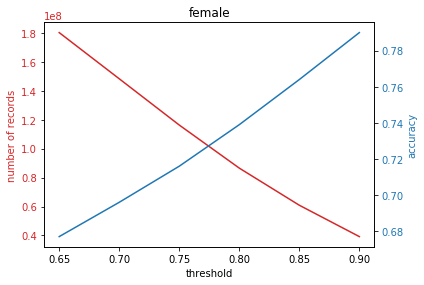

In [122]:
double_axis(f_cnt,f_acc,'female','number of records','accuracy')

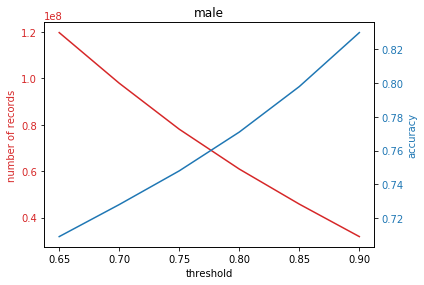

In [123]:
double_axis(m_cnt,m_acc,'male','number of records','accuracy')

For our previous profiles, we have about 9 million estimations for either male or female (clean supply and prediction). The plots above show the prediction accuracy and number of estimations we get vs the threshold. For the male prediction, I think maybe we can choose the threshold around 0.8, in this way we have about 7 million estimation from prediction with accuracy around 0.78. As for the female threshold, maybe choose a value between 0.8 and 0.85, so that we have about 7 million estimations and about 0.76 accuracy. Does this accuracy good enough? I think if we change the feature from binary to tf-idf, we should be able to improve the accuracy.

# Predicted Age

In [160]:
dat_age = dat.loc[dat.filename.str.contains('^age_\d\d_\d\d\d\d\d\d_\d\d')]
age_dat = agg_gender(dat_age)
age_dat.index = range(age_dat.shape[0])
age_dat = age_dat.drop(range(6))
age_dat.index = range(age_dat.shape[0])

In the table below, the filename is in the format of age_bracket_171231_threshold.

In [161]:
age_dat

,filename,18,25,35,45,55,65
0,age_18_171231_65,0.362608,0.269136,0.148696,0.107248,0.062248,0.049656
1,age_18_171231_70,0.380315,0.263390,0.142950,0.104520,0.060710,0.048115
2,age_18_171231_75,0.394851,0.259120,0.137776,0.101358,0.059149,0.047149
3,age_18_171231_80,0.404252,0.254756,0.134384,0.100152,0.059132,0.048324
4,age_18_171231_85,0.406908,0.250178,0.132773,0.100092,0.060229,0.049411
5,age_18_171231_90,0.400140,0.248630,0.132828,0.102446,0.063306,0.052650
6,age_25_171231_65,0.170510,0.275800,0.212060,0.164600,0.110020,0.066540
7,age_25_171231_70,0.170946,0.275760,0.211531,0.165151,0.110523,0.066558
8,age_25_171231_75,0.172345,0.275680,0.211066,0.164193,0.110655,0.066061
9,age_25_171231_80,0.174594,0.277446,0.210611,0.163888,0.109258,0.064129


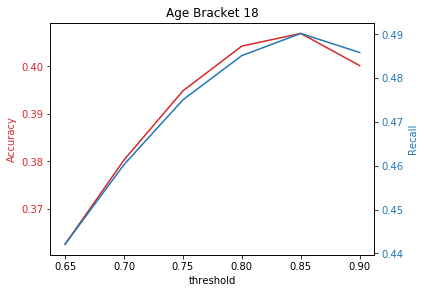

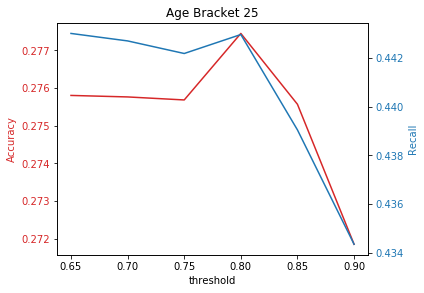

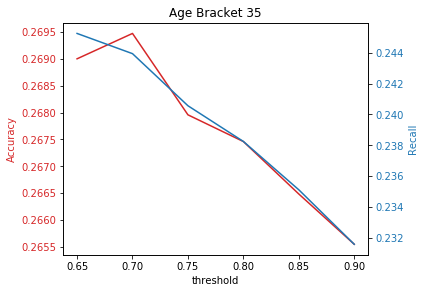

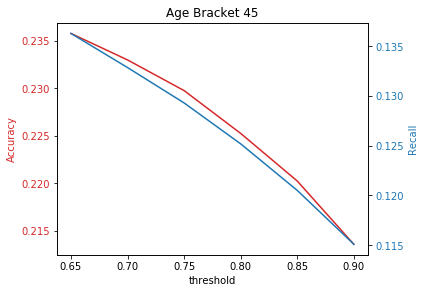

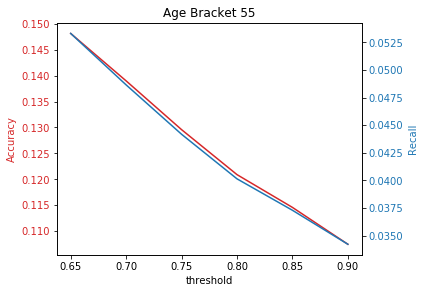

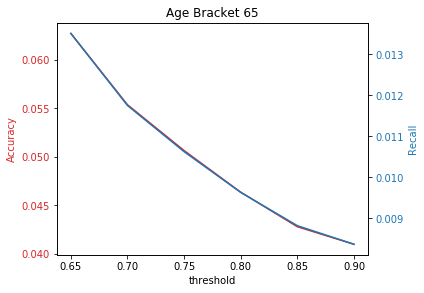

In [170]:
for pat in ['_18_','_25_','_35_','_45_','_55_','_65_']:
    dat1 = age_dat.loc[age_dat.filename.str.contains(pat)]
    acc, rec = [], []
    for index, row in dat1.iterrows():
#        print(row)
#        print(pat)
        acc.append(float(row[pat[1:3]]))
        rec.append(recall_ext(row,pat[1:3]))
    double_axis(pd.Series(acc),pd.Series(rec),'Age Bracket '+pat[1:3],'Accuracy', 'Recall')

As it shows in the plots above. The predicted accuracy and recall for age brackets are very poor. To the extend that when we increase the threshold, the accuracy and recall for some brackets even dropped (probably indicates that the classifier is worse than random guess). I think one most important reason is still that the labels for those classes are not accurate enough, and we should probably start from there.